In [1]:
import numpy as np
import torch
import pyepo

# set random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Obj: 58.1424
0 -> 10 -> 15 -> 8 -> 5 -> 3 -> 17 -> 1 -> 6 -> 13 -> 19 -> 11 -> 18 -> 7 -> 2 -> 14 -> 12 -> 4 -> 9 -> 16 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.39it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 127.64it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.93it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.12it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-0.5, num_epochs+0.5)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 20
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                # restore best model
                reg.load_state_dict(best_model_state)
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func, grad_log):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                              loader_train_cost, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:10<?, ?it/s]

Epoch   0, Train Regret: 216.6579%, Val Regret: 224.0108%


Epoch    0, Loss:  34.2506:   5%|██▊                                                    | 1/20 [00:21<03:47, 11.95s/it]

Epoch   1, Train Regret:  24.5034%, Val Regret:  24.2981%


Epoch    1, Loss:  19.2669:  10%|█████▌                                                 | 2/20 [00:31<03:22, 11.25s/it]

Epoch   2, Train Regret:  21.8651%, Val Regret:  22.1734%


Epoch    2, Loss:  23.4411:  15%|████████▎                                              | 3/20 [00:42<03:02, 10.73s/it]

Epoch   3, Train Regret:  20.6678%, Val Regret:  20.6605%


Epoch    3, Loss:  21.6620:  20%|███████████                                            | 4/20 [00:52<02:50, 10.69s/it]

Epoch   4, Train Regret:  19.7073%, Val Regret:  19.6866%


Epoch    4, Loss:   8.4527:  25%|█████████████▊                                         | 5/20 [01:02<02:37, 10.50s/it]

Epoch   5, Train Regret:  18.1748%, Val Regret:  18.4411%


Epoch    5, Loss:  11.9667:  30%|████████████████▌                                      | 6/20 [01:13<02:24, 10.35s/it]

Epoch   6, Train Regret:  16.3925%, Val Regret:  16.9329%


Epoch    6, Loss:   9.6950:  35%|███████████████████▎                                   | 7/20 [01:23<02:15, 10.39s/it]

Epoch   7, Train Regret:  15.3700%, Val Regret:  15.7292%


Epoch    7, Loss:   5.8913:  40%|██████████████████████                                 | 8/20 [01:33<02:03, 10.31s/it]

Epoch   8, Train Regret:  14.5283%, Val Regret:  14.9727%


Epoch    8, Loss:   9.1741:  45%|████████████████████████▊                              | 9/20 [01:43<01:52, 10.22s/it]

Epoch   9, Train Regret:  13.9677%, Val Regret:  14.6126%


Epoch    9, Loss:   8.1964:  50%|███████████████████████████                           | 10/20 [01:53<01:41, 10.13s/it]

Epoch  10, Train Regret:  13.7533%, Val Regret:  14.6126%


Epoch   10, Loss:  12.2435:  55%|█████████████████████████████▋                        | 11/20 [02:03<01:31, 10.14s/it]

Epoch  11, Train Regret:  13.4047%, Val Regret:  14.0823%


Epoch   11, Loss:  10.8563:  60%|████████████████████████████████▍                     | 12/20 [02:13<01:21, 10.15s/it]

Epoch  12, Train Regret:  13.1978%, Val Regret:  13.7226%


Epoch   12, Loss:  10.1927:  65%|███████████████████████████████████                   | 13/20 [02:23<01:11, 10.19s/it]

Epoch  13, Train Regret:  13.3223%, Val Regret:  13.9320%


Epoch   13, Loss:  13.8770:  70%|█████████████████████████████████████▊                | 14/20 [02:33<01:00, 10.11s/it]

Epoch  14, Train Regret:  13.2145%, Val Regret:  13.5664%


Epoch   14, Loss:   6.6662:  75%|████████████████████████████████████████▌             | 15/20 [02:43<00:50, 10.05s/it]

Epoch  15, Train Regret:  13.2562%, Val Regret:  13.6719%


Epoch   15, Loss:  16.8497:  80%|███████████████████████████████████████████▏          | 16/20 [02:53<00:40, 10.03s/it]

Epoch  16, Train Regret:  13.0987%, Val Regret:  13.3092%


Epoch   16, Loss:   6.7349:  85%|█████████████████████████████████████████████▉        | 17/20 [03:03<00:29,  9.98s/it]

Epoch  17, Train Regret:  13.2471%, Val Regret:  13.3661%


Epoch   17, Loss:   8.5397:  90%|████████████████████████████████████████████████▌     | 18/20 [03:13<00:20, 10.00s/it]

Epoch  18, Train Regret:  13.1883%, Val Regret:  13.4162%


Epoch   18, Loss:   8.5746:  95%|███████████████████████████████████████████████████▎  | 19/20 [03:23<00:10, 10.70s/it]


Epoch  19, Train Regret:  13.3162%, Val Regret:  13.5088%

Early Stop!

Evaluation:
Test Regret: 13.5085%
Training Elapsed Time: 2.49 Sec


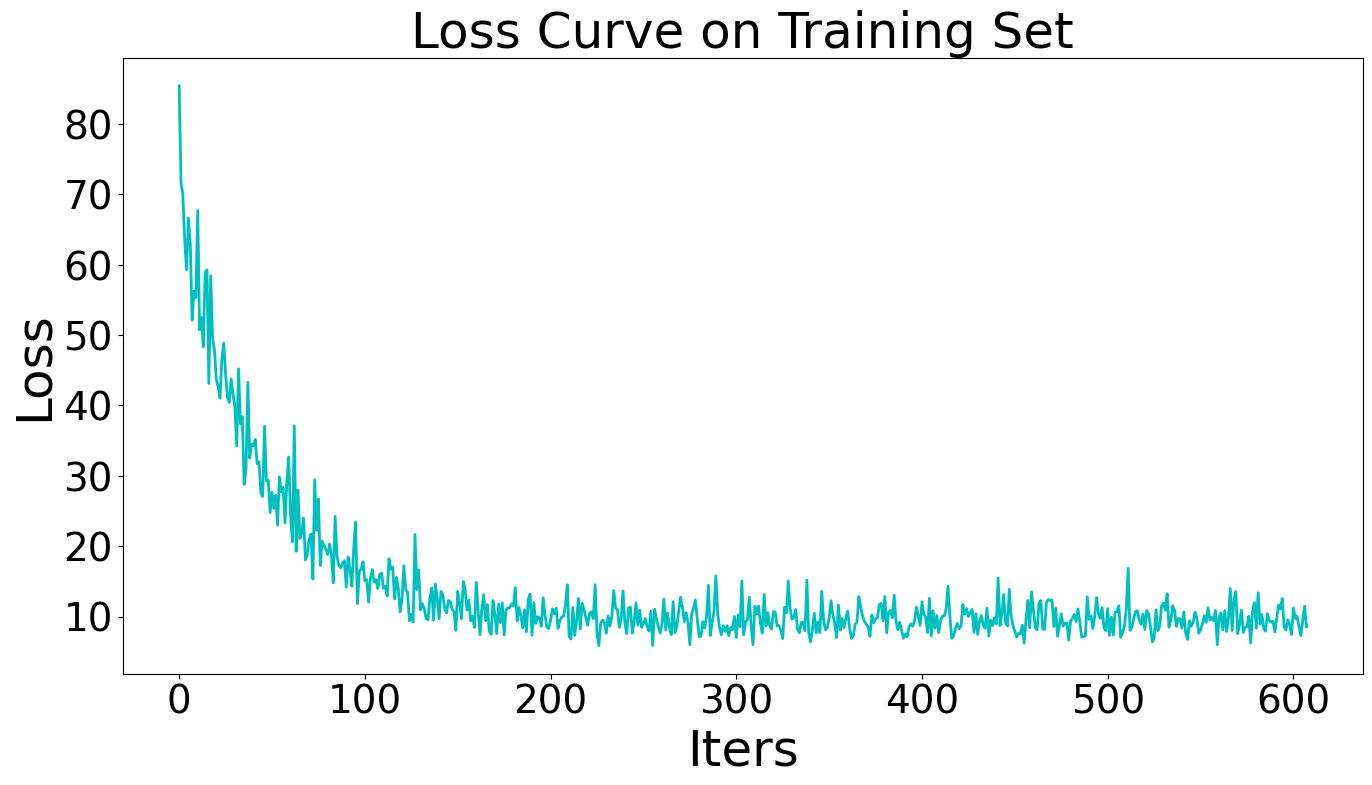

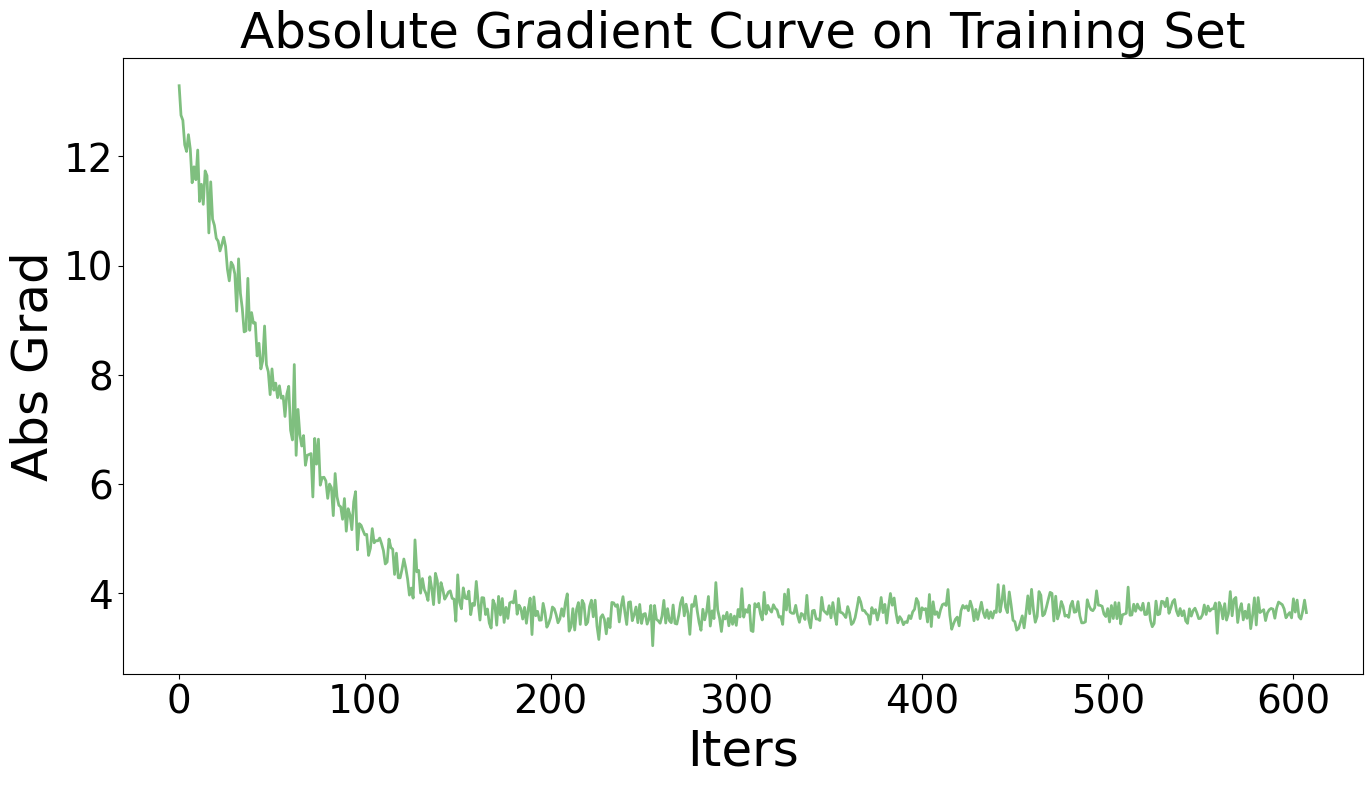

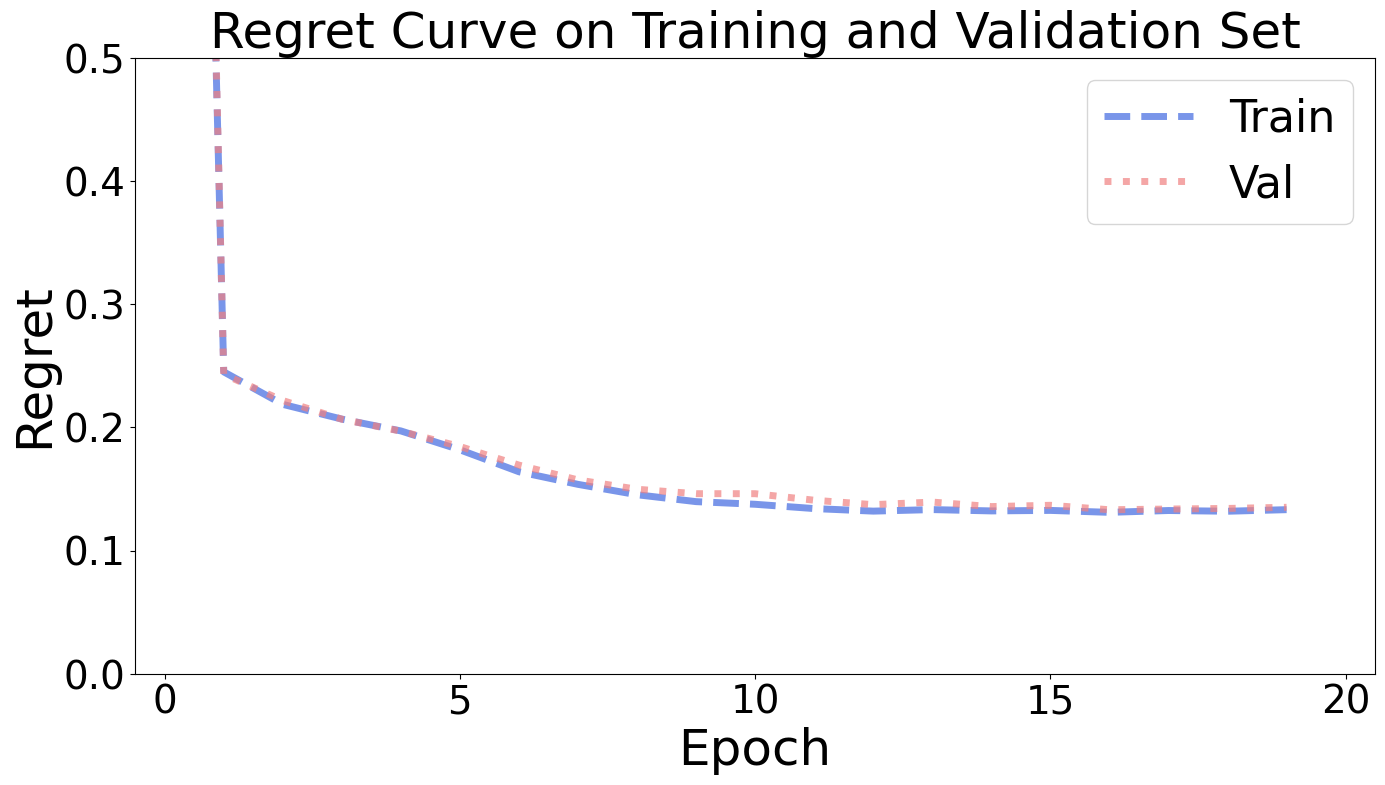

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

Num of cores: 8


In [18]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:08<?, ?it/s]

Epoch   0, Train Regret: 206.4504%, Val Regret: 210.3446%


Epoch    0, Loss:  -0.9973:   5%|██▊                                                    | 1/20 [00:26<05:33, 17.57s/it]

Epoch   1, Train Regret:  11.3955%, Val Regret:  12.4876%


Epoch    1, Loss:  -0.9984:  10%|█████▌                                                 | 2/20 [00:39<04:23, 14.64s/it]

Epoch   2, Train Regret:   8.2735%, Val Regret:   9.0998%


Epoch    2, Loss:  -0.9988:  15%|████████▎                                              | 3/20 [00:52<03:54, 13.76s/it]

Epoch   3, Train Regret:   7.1709%, Val Regret:   8.0982%


Epoch    3, Loss:  -0.9996:  20%|███████████                                            | 4/20 [01:04<03:30, 13.18s/it]

Epoch   4, Train Regret:   6.9633%, Val Regret:   8.2193%


Epoch    4, Loss:  -0.9996:  25%|█████████████▊                                         | 5/20 [01:16<03:12, 12.84s/it]

Epoch   5, Train Regret:   6.7131%, Val Regret:   7.8406%


Epoch    5, Loss:  -0.9996:  30%|████████████████▌                                      | 6/20 [01:28<02:57, 12.65s/it]

Epoch   6, Train Regret:   6.6994%, Val Regret:   7.6676%


Epoch    6, Loss:  -0.9991:  35%|███████████████████▎                                   | 7/20 [01:41<02:42, 12.53s/it]

Epoch   7, Train Regret:   6.8023%, Val Regret:   7.9296%


Epoch    7, Loss:  -0.9994:  40%|██████████████████████                                 | 8/20 [01:53<02:30, 12.51s/it]

Epoch   8, Train Regret:   6.8204%, Val Regret:   7.3081%


Epoch    8, Loss:  -0.9996:  45%|████████████████████████▊                              | 9/20 [02:05<02:16, 12.40s/it]

Epoch   9, Train Regret:   6.7058%, Val Regret:   7.8426%


Epoch    9, Loss:  -0.9996:  50%|███████████████████████████                           | 10/20 [02:17<02:02, 12.29s/it]

Epoch  10, Train Regret:   6.8195%, Val Regret:   7.4588%


Epoch   10, Loss:  -0.9996:  55%|█████████████████████████████▋                        | 11/20 [02:30<02:03, 13.68s/it]


Epoch  11, Train Regret:   6.8169%, Val Regret:   7.3527%

Early Stop!

Evaluation:
Test Regret: 7.1923%
Training Elapsed Time: 29.23 Sec


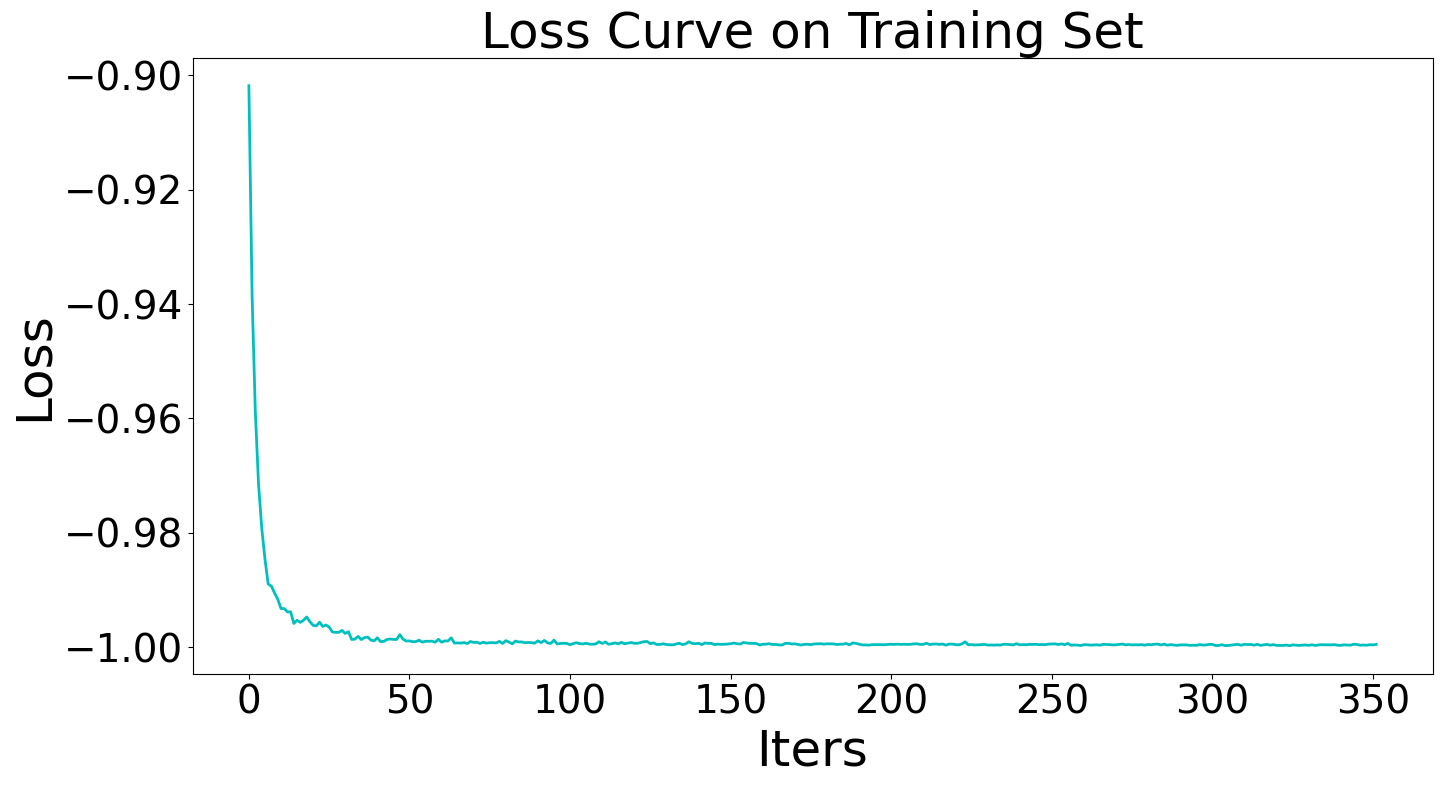

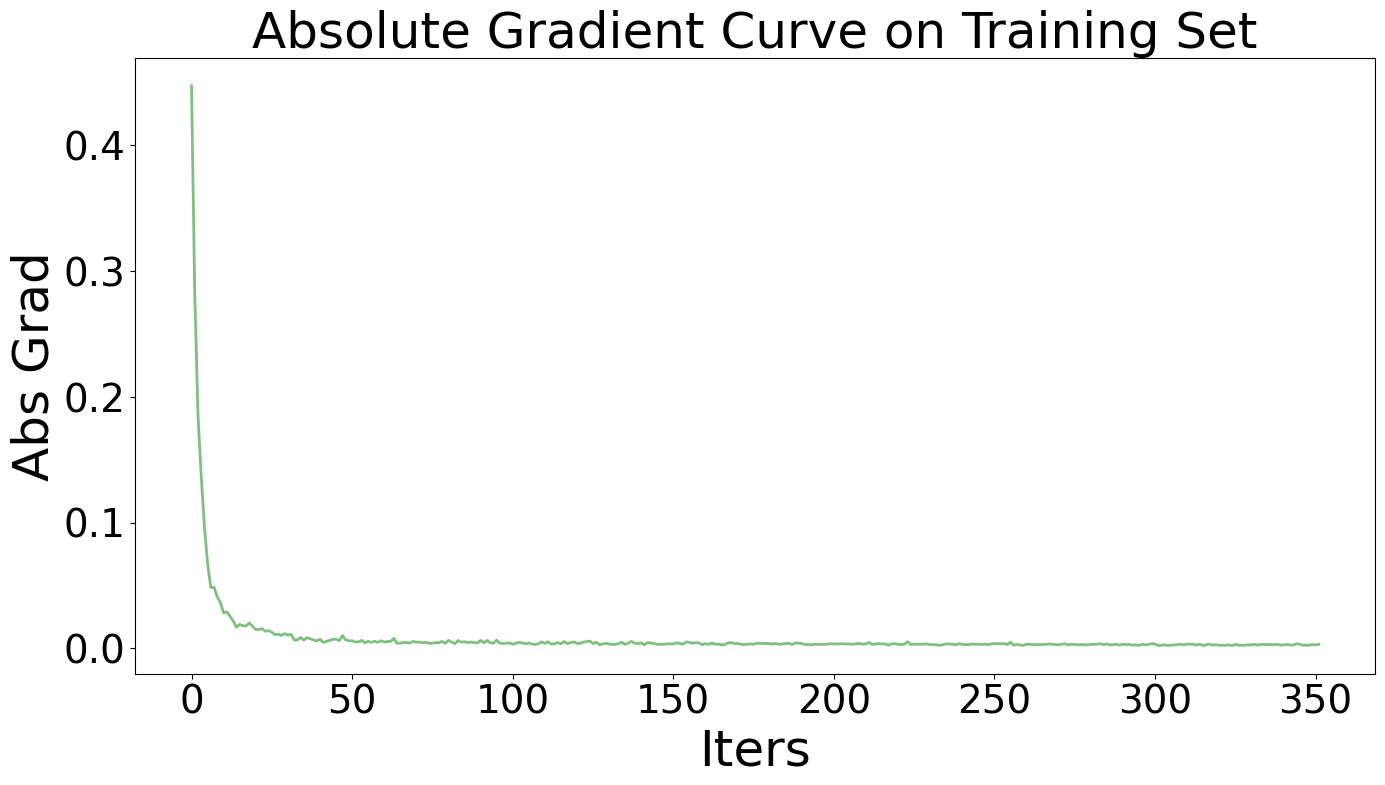

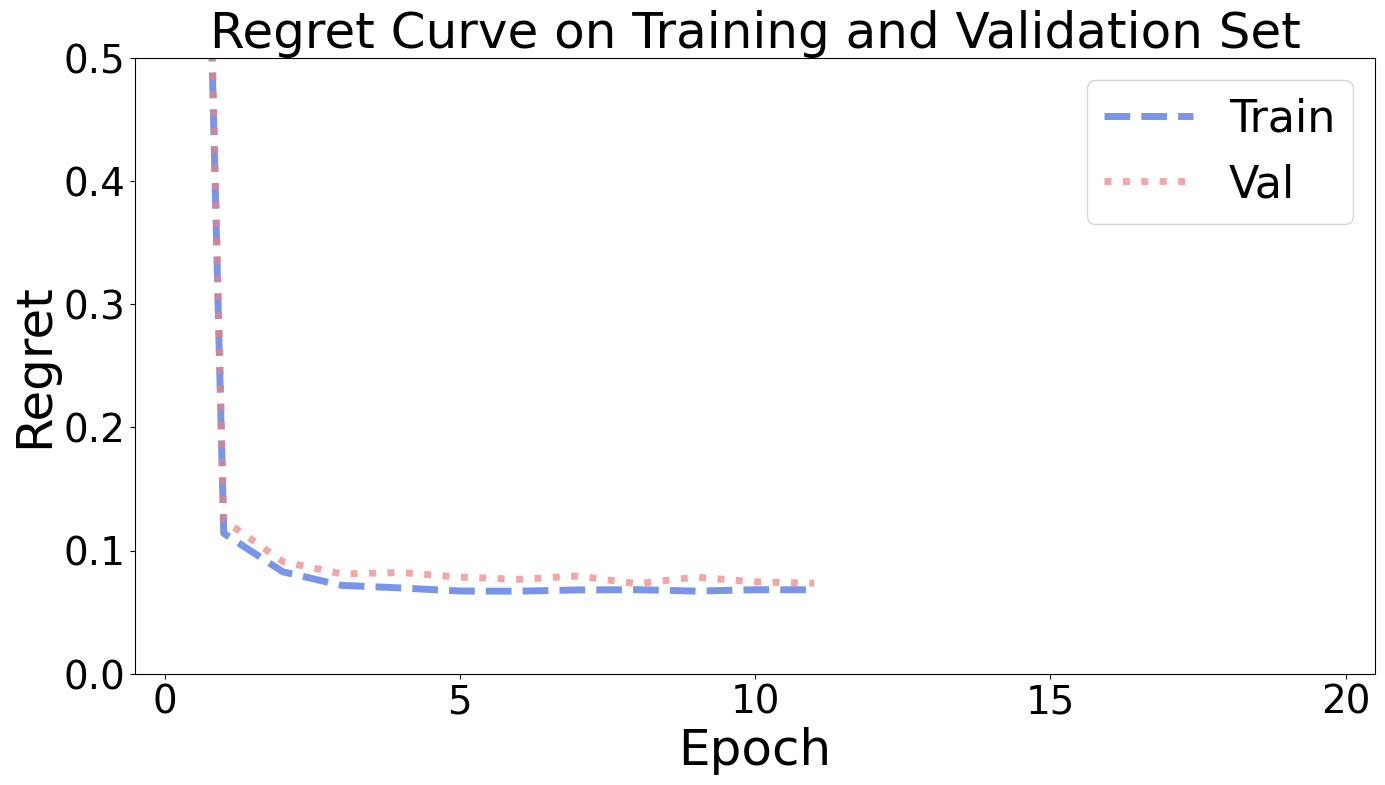

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with NNLS

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="nnls", processes=8)

Num of cores: 8


In [22]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 196.7550%, Val Regret: 196.5337%


Epoch    0, Loss:  -0.9976:   5%|██▊                                                    | 1/20 [00:21<03:51, 12.18s/it]

Epoch   1, Train Regret:  12.0926%, Val Regret:  13.4782%


Epoch    1, Loss:  -0.9986:  10%|█████▌                                                 | 2/20 [00:33<03:40, 12.26s/it]

Epoch   2, Train Regret:   8.1462%, Val Regret:   8.8973%


Epoch    2, Loss:  -0.9988:  15%|████████▎                                              | 3/20 [00:46<03:29, 12.34s/it]

Epoch   3, Train Regret:   7.4316%, Val Regret:   7.5924%


Epoch    3, Loss:  -0.9994:  20%|███████████                                            | 4/20 [00:58<03:16, 12.30s/it]

Epoch   4, Train Regret:   6.8525%, Val Regret:   7.6207%


Epoch    4, Loss:  -0.9996:  25%|█████████████▊                                         | 5/20 [01:11<03:04, 12.28s/it]

Epoch   5, Train Regret:   6.8249%, Val Regret:   7.1908%


Epoch    5, Loss:  -0.9996:  30%|████████████████▌                                      | 6/20 [01:24<02:55, 12.52s/it]

Epoch   6, Train Regret:   6.8807%, Val Regret:   7.2108%


Epoch    6, Loss:  -0.9992:  35%|███████████████████▎                                   | 7/20 [01:36<02:43, 12.59s/it]

Epoch   7, Train Regret:   6.7286%, Val Regret:   7.1483%


Epoch    7, Loss:  -0.9994:  40%|██████████████████████                                 | 8/20 [01:48<02:30, 12.54s/it]

Epoch   8, Train Regret:   6.8099%, Val Regret:   7.0996%


Epoch    8, Loss:  -0.9996:  45%|████████████████████████▊                              | 9/20 [02:01<02:17, 12.53s/it]

Epoch   9, Train Regret:   6.7906%, Val Regret:   7.2709%


Epoch    9, Loss:  -0.9996:  50%|███████████████████████████                           | 10/20 [02:13<02:05, 12.55s/it]

Epoch  10, Train Regret:   6.8790%, Val Regret:   7.1954%


Epoch   10, Loss:  -0.9996:  55%|█████████████████████████████▋                        | 11/20 [02:25<01:51, 12.42s/it]

Epoch  11, Train Regret:   6.7743%, Val Regret:   7.0703%


Epoch   11, Loss:  -0.9996:  60%|████████████████████████████████▍                     | 12/20 [02:38<01:38, 12.35s/it]

Epoch  12, Train Regret:   6.6416%, Val Regret:   6.0915%


Epoch   12, Loss:  -0.9996:  65%|███████████████████████████████████                   | 13/20 [02:50<01:26, 12.37s/it]

Epoch  13, Train Regret:   6.9579%, Val Regret:   7.2540%


Epoch   13, Loss:  -0.9996:  70%|█████████████████████████████████████▊                | 14/20 [03:02<01:13, 12.32s/it]

Epoch  14, Train Regret:   6.6767%, Val Regret:   6.6278%


Epoch   14, Loss:  -0.9997:  75%|████████████████████████████████████████▌             | 15/20 [03:15<01:05, 13.01s/it]


Epoch  15, Train Regret:   6.9998%, Val Regret:   6.9330%

Early Stop!

Evaluation:
Test Regret: 7.1187%
Training Elapsed Time: 31.21 Sec


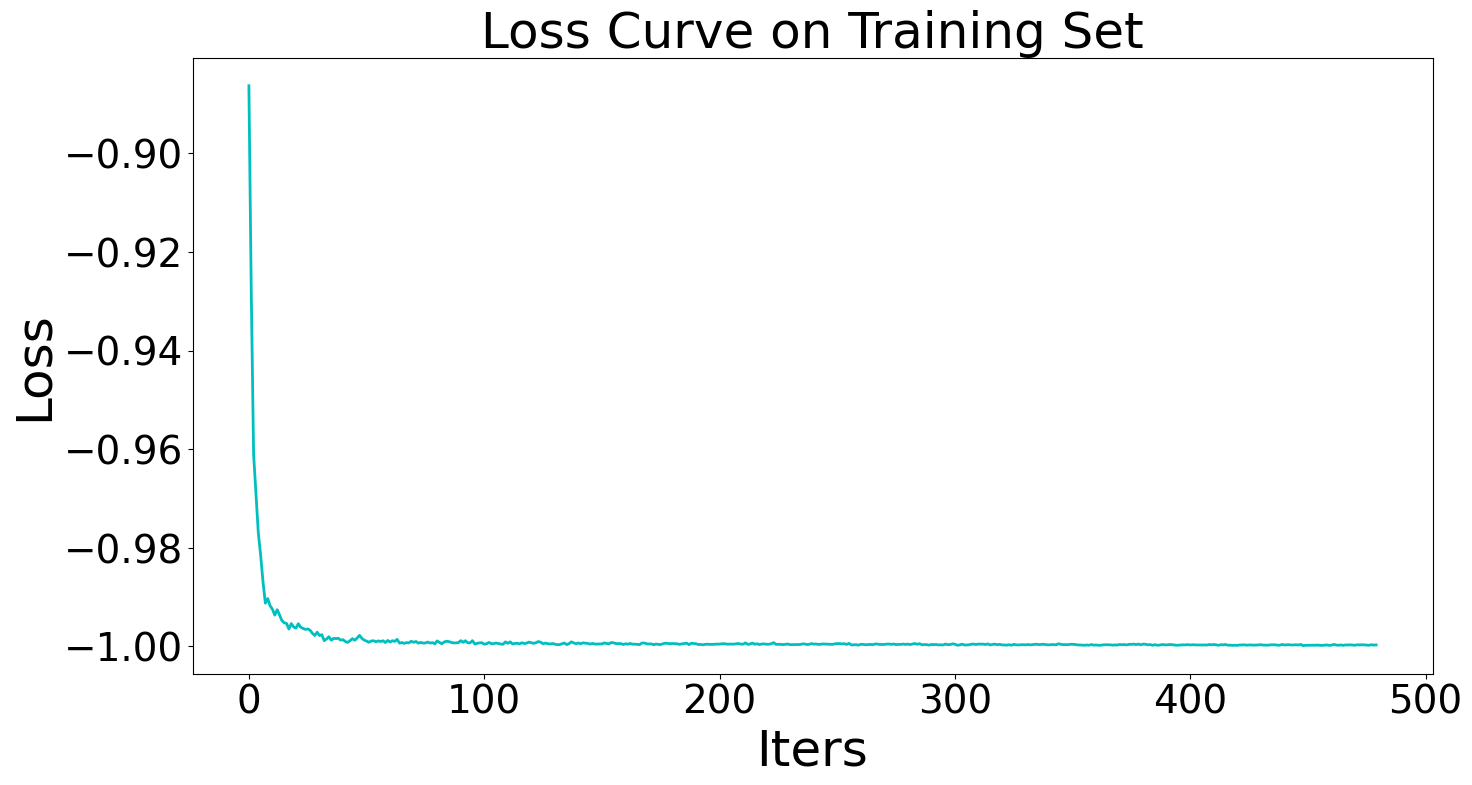

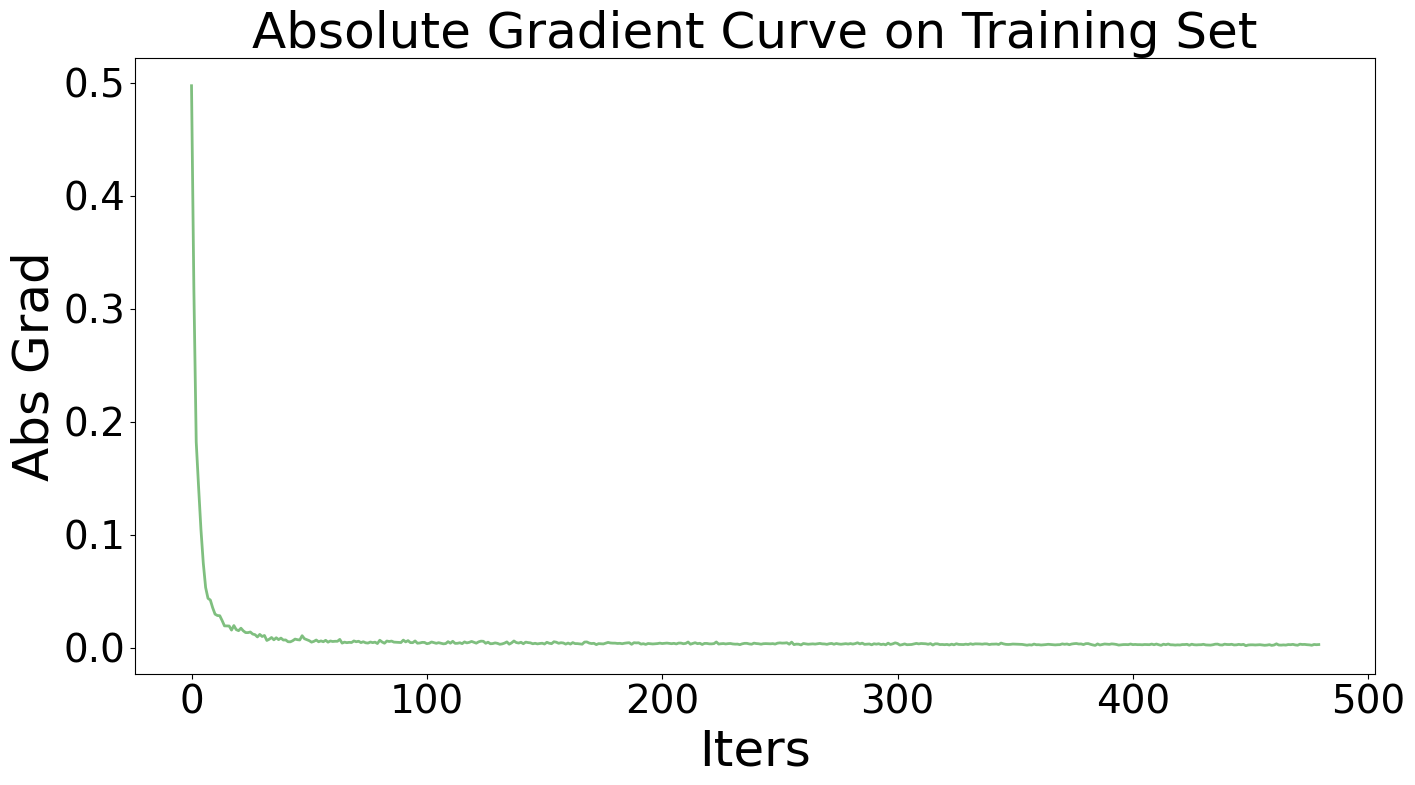

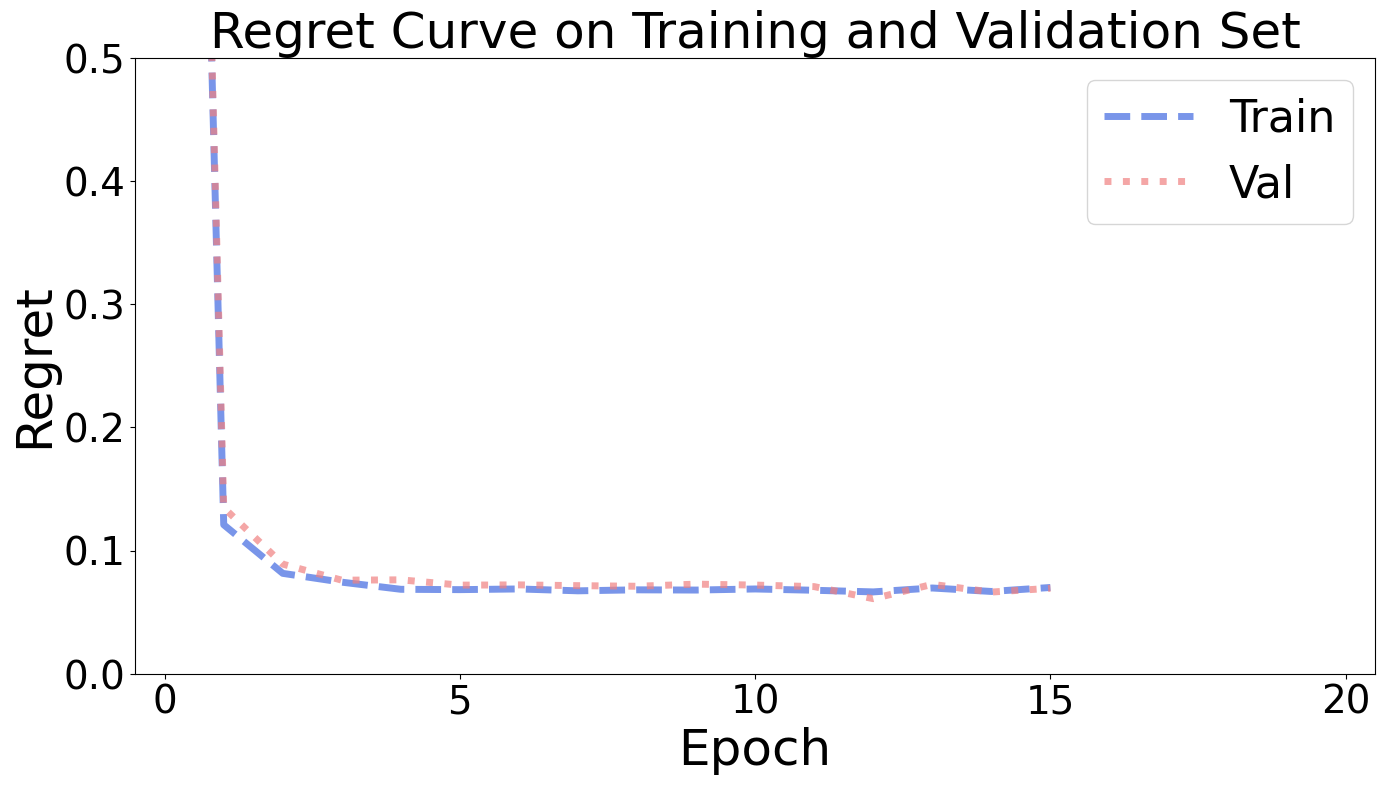

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [26]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:08<?, ?it/s]

Epoch   0, Train Regret: 192.3041%, Val Regret: 194.3730%


Epoch    0, Loss:  -0.7590:   5%|██▊                                                    | 1/20 [00:21<03:40, 11.59s/it]

Epoch   1, Train Regret:  17.5609%, Val Regret:  17.4965%


Epoch    1, Loss:  -0.7655:  10%|█████▌                                                 | 2/20 [00:32<03:29, 11.63s/it]

Epoch   2, Train Regret:  15.2793%, Val Regret:  14.8964%


Epoch    2, Loss:  -0.7091:  15%|████████▎                                              | 3/20 [00:44<03:18, 11.70s/it]

Epoch   3, Train Regret:  14.5372%, Val Regret:  15.8378%


Epoch    3, Loss:  -0.8034:  20%|███████████                                            | 4/20 [00:56<03:07, 11.73s/it]

Epoch   4, Train Regret:  14.9848%, Val Regret:  16.0403%


Epoch    4, Loss:  -0.7980:  25%|█████████████▊                                         | 5/20 [01:07<03:22, 13.50s/it]


Epoch   5, Train Regret:  15.1437%, Val Regret:  15.4026%

Early Stop!

Evaluation:
Test Regret: 15.9934%
Training Elapsed Time: 6.42 Sec


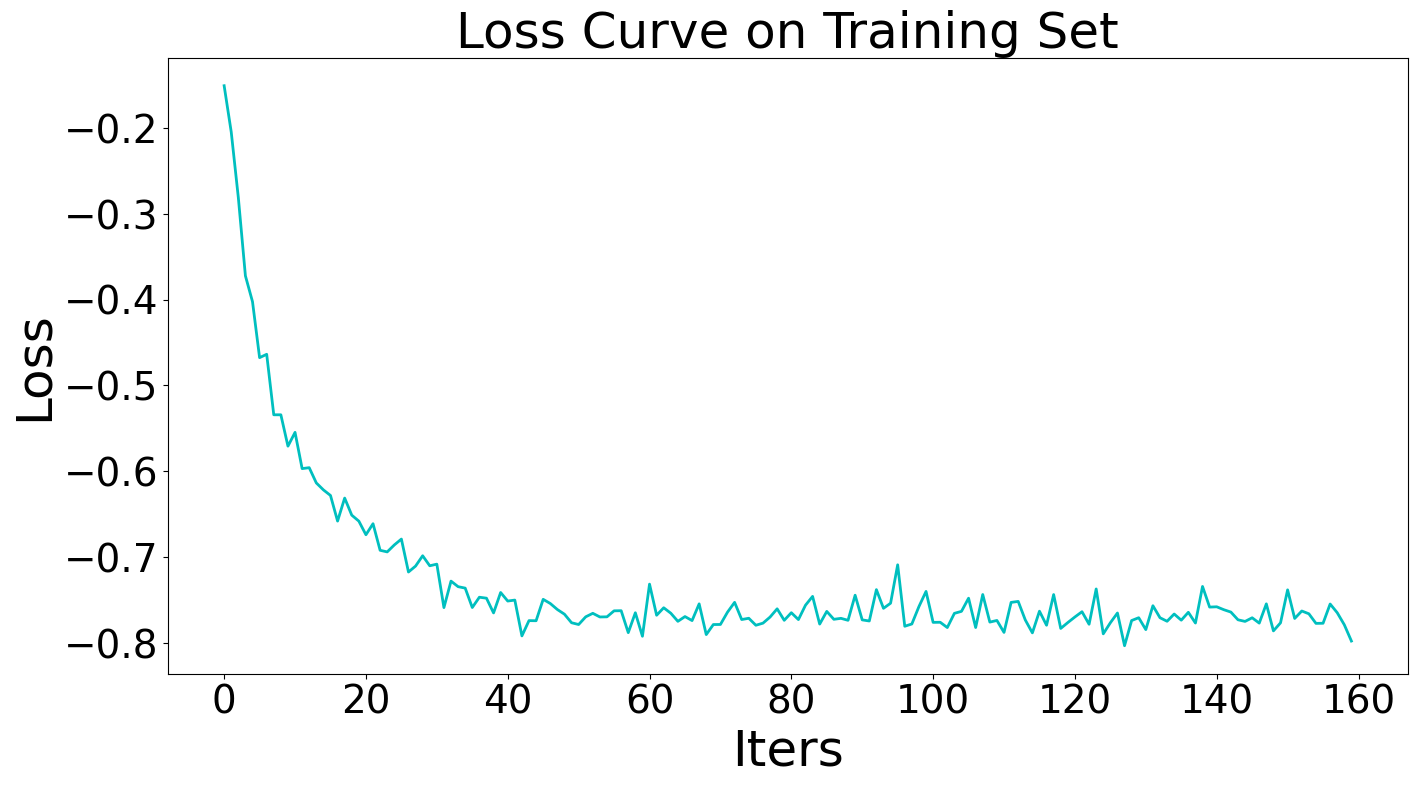

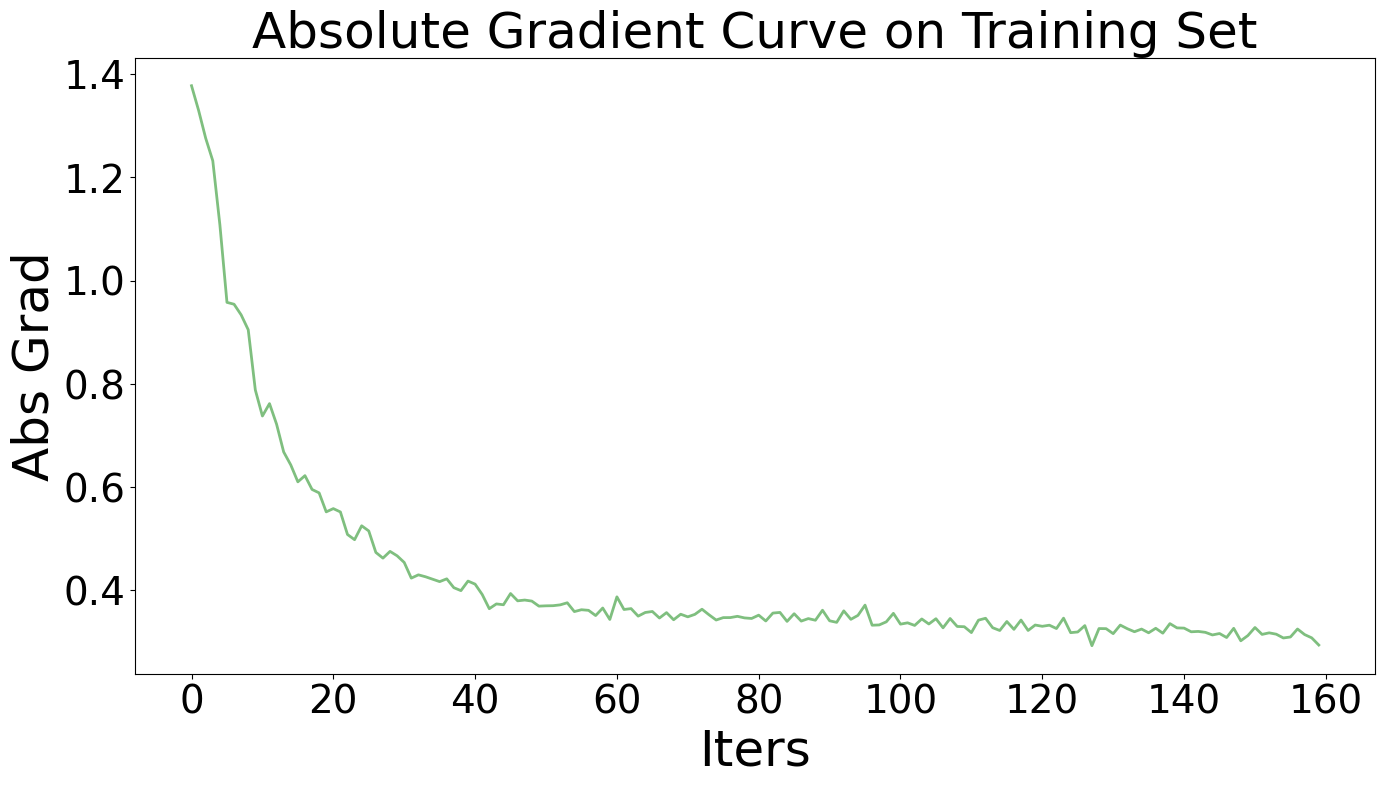

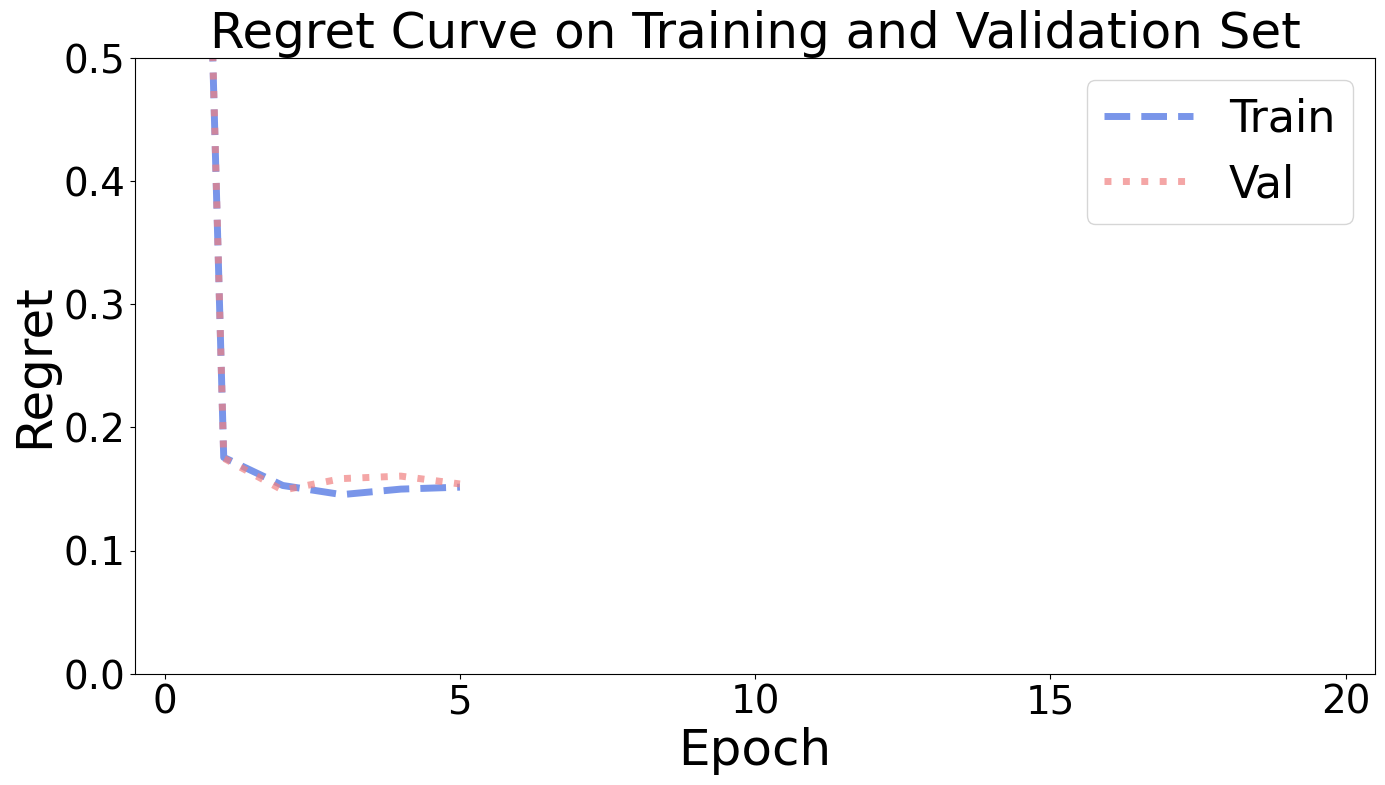

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

In [30]:
lr =1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:08<?, ?it/s]

Epoch   0, Train Regret: 188.6278%, Val Regret: 199.1169%


Epoch    0, Loss:  -0.5630:   5%|██▊                                                    | 1/20 [00:19<03:13, 10.16s/it]

Epoch   1, Train Regret:  44.6450%, Val Regret:  48.3797%


Epoch    1, Loss:  -0.6739:  10%|█████▌                                                 | 2/20 [00:29<03:03, 10.19s/it]

Epoch   2, Train Regret:  12.8450%, Val Regret:  14.8698%


Epoch    2, Loss:  -0.6057:  15%|████████▎                                              | 3/20 [00:40<02:55, 10.35s/it]

Epoch   3, Train Regret:  12.8541%, Val Regret:  13.0760%


Epoch    3, Loss:  -0.7530:  20%|███████████                                            | 4/20 [00:51<02:47, 10.48s/it]

Epoch   4, Train Regret:  12.9113%, Val Regret:  12.9479%


Epoch    4, Loss:  -0.8401:  25%|█████████████▊                                         | 5/20 [01:01<02:38, 10.59s/it]

Epoch   5, Train Regret:  13.2404%, Val Regret:  13.2660%


Epoch    5, Loss:  -0.7478:  30%|████████████████▌                                      | 6/20 [01:12<02:29, 10.65s/it]

Epoch   6, Train Regret:  13.0708%, Val Regret:  13.5117%


Epoch    6, Loss:  -0.6744:  35%|███████████████████▎                                   | 7/20 [01:23<02:35, 11.92s/it]


Epoch   7, Train Regret:  12.6215%, Val Regret:  13.0951%

Early Stop!

Evaluation:
Test Regret: 13.7213%
Training Elapsed Time: 1.58 Sec


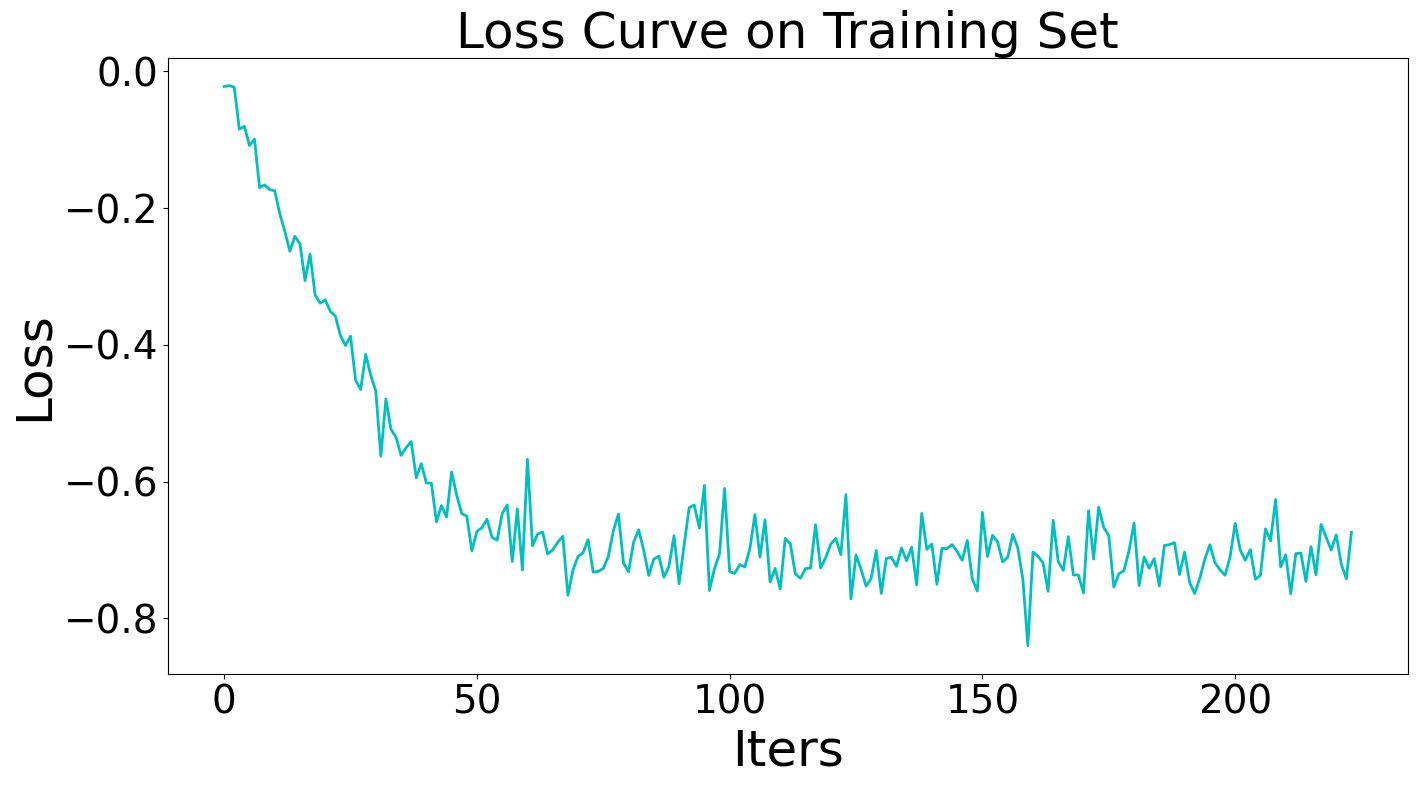

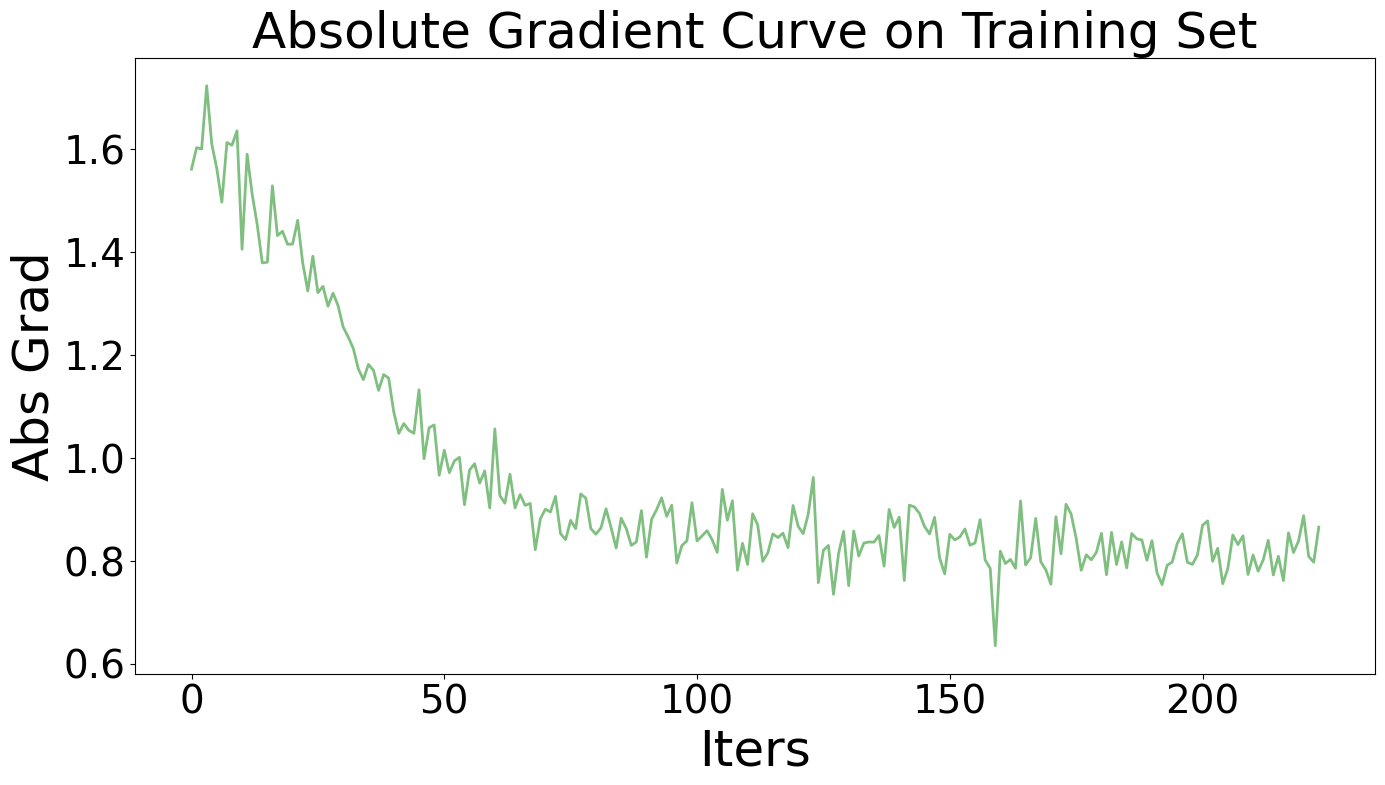

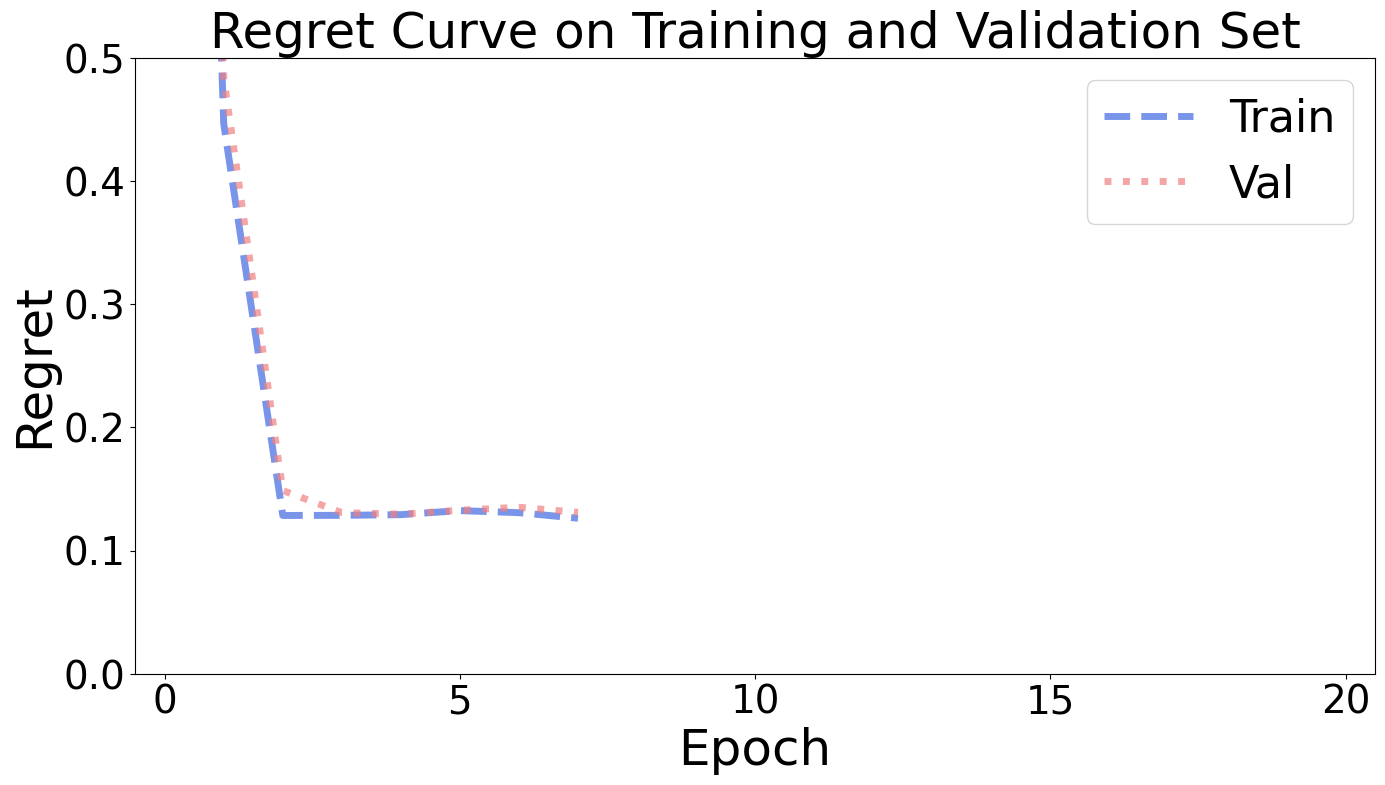

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [34]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 208.7782%, Val Regret: 214.8391%


Epoch    0, Loss:  17.5000:   5%|██▊                                                    | 1/20 [00:21<04:00, 12.65s/it]

Epoch   1, Train Regret:   9.0930%, Val Regret:   9.9594%


Epoch    1, Loss:  20.5000:  10%|█████▌                                                 | 2/20 [00:34<03:48, 12.68s/it]

Epoch   2, Train Regret:   7.1511%, Val Regret:   7.5206%


Epoch    2, Loss:  17.7500:  15%|████████▎                                              | 3/20 [00:47<03:35, 12.66s/it]

Epoch   3, Train Regret:   6.6410%, Val Regret:   7.6496%


Epoch    3, Loss:  15.5000:  20%|███████████                                            | 4/20 [00:59<03:22, 12.68s/it]

Epoch   4, Train Regret:   6.3705%, Val Regret:   8.0452%


Epoch    4, Loss:  15.2500:  25%|█████████████▊                                         | 5/20 [01:12<03:11, 12.79s/it]

Epoch   5, Train Regret:   6.2268%, Val Regret:   7.1505%


Epoch    5, Loss:  15.5000:  30%|████████████████▌                                      | 6/20 [01:25<02:58, 12.72s/it]

Epoch   6, Train Regret:   6.1256%, Val Regret:   6.7490%


Epoch    6, Loss:  15.7500:  35%|███████████████████▎                                   | 7/20 [01:38<02:46, 12.80s/it]

Epoch   7, Train Regret:   5.9310%, Val Regret:   6.6735%


Epoch    7, Loss:  17.5000:  40%|██████████████████████                                 | 8/20 [01:51<02:34, 12.87s/it]

Epoch   8, Train Regret:   5.8655%, Val Regret:   7.4020%


Epoch    8, Loss:  14.7500:  45%|████████████████████████▊                              | 9/20 [02:04<02:22, 12.95s/it]

Epoch   9, Train Regret:   6.0933%, Val Regret:   7.2255%


Epoch    9, Loss:  15.5000:  50%|███████████████████████████                           | 10/20 [02:17<02:17, 13.74s/it]


Epoch  10, Train Regret:   5.9522%, Val Regret:   7.0034%

Early Stop!

Evaluation:
Test Regret: 6.4933%
Training Elapsed Time: 26.16 Sec


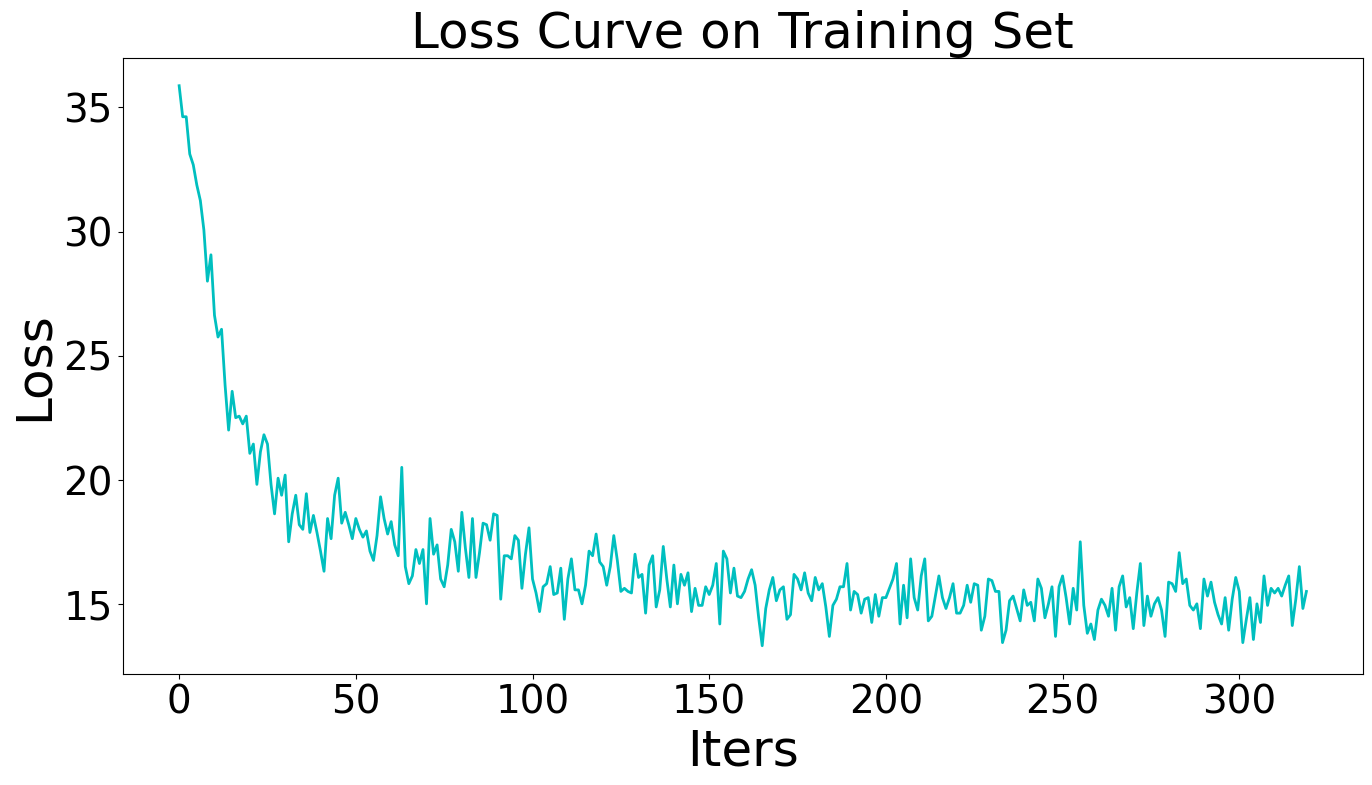

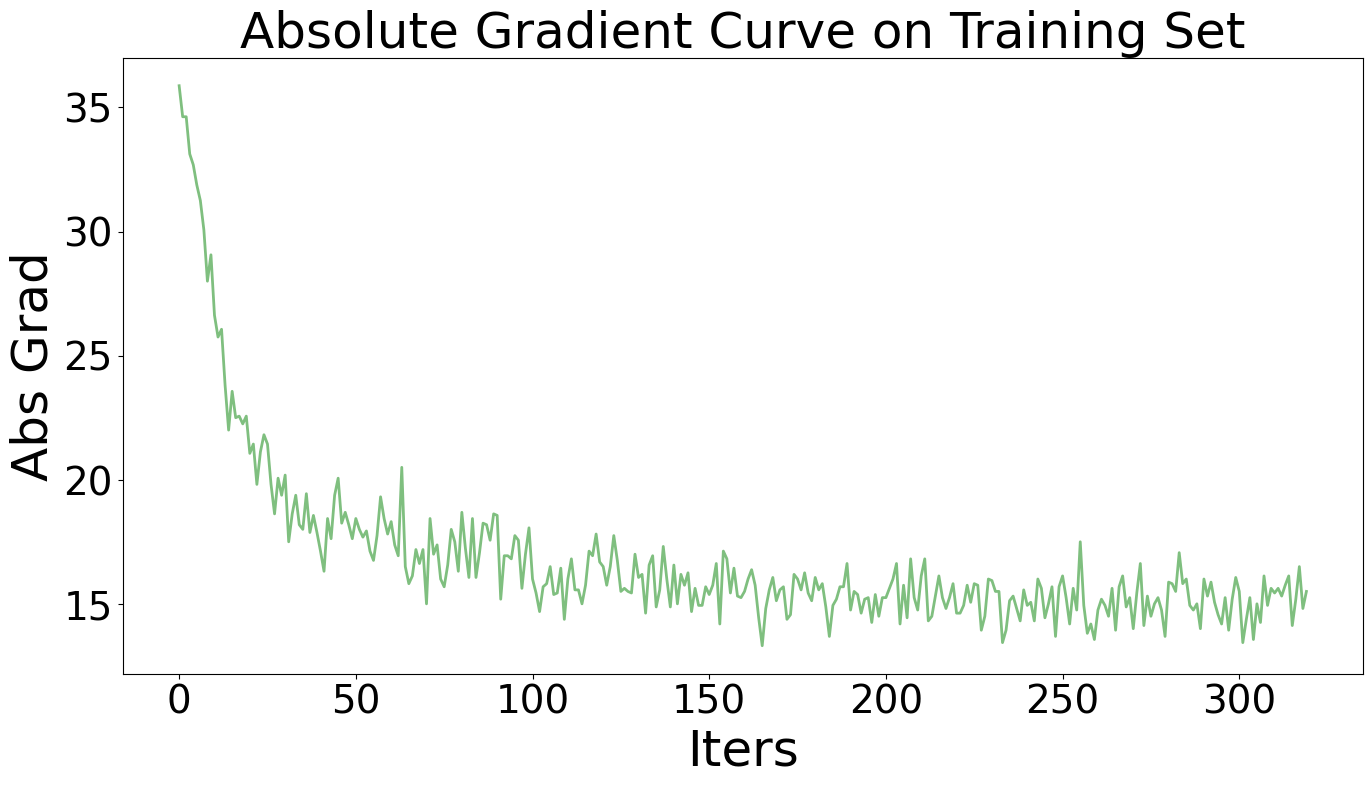

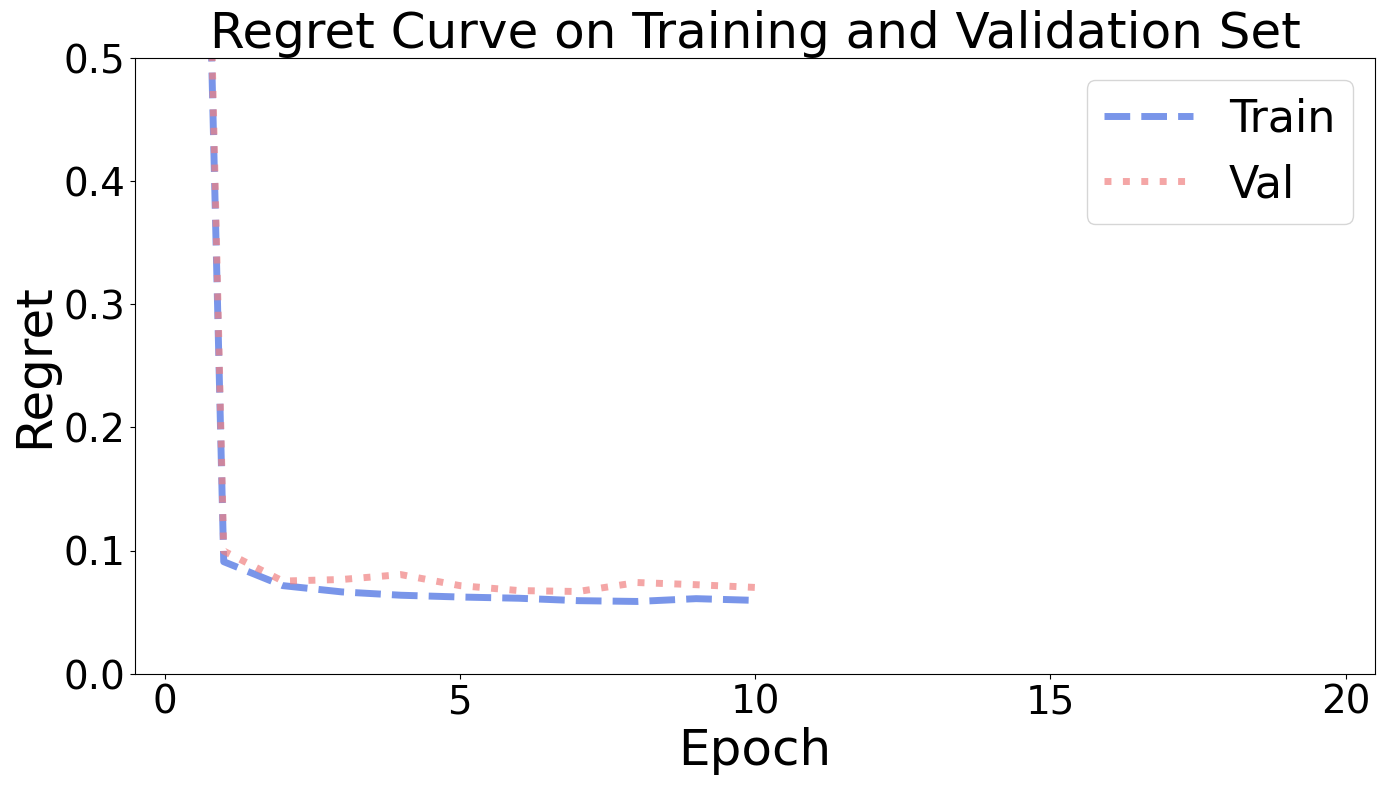

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [36]:
# init model
reg = LinearRegression()

In [37]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [38]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 206.8764%, Val Regret: 207.7709%


Epoch    0, Loss: -58.1889:   5%|██▊                                                    | 1/20 [00:19<03:23, 10.69s/it]

Epoch   1, Train Regret:  19.0112%, Val Regret:  19.1309%


Epoch    1, Loss: -123.5104:  10%|█████▍                                                | 2/20 [00:29<03:07, 10.43s/it]

Epoch   2, Train Regret:  15.2404%, Val Regret:  16.7449%


Epoch    2, Loss: -194.9332:  15%|████████                                              | 3/20 [00:39<02:55, 10.31s/it]

Epoch   3, Train Regret:  13.9691%, Val Regret:  15.8851%


Epoch    3, Loss: -298.8772:  20%|██████████▊                                           | 4/20 [00:49<02:43, 10.21s/it]

Epoch   4, Train Regret:  13.5869%, Val Regret:  15.3628%


Epoch    4, Loss: -332.7184:  25%|█████████████▌                                        | 5/20 [01:00<02:32, 10.20s/it]

Epoch   5, Train Regret:  13.1072%, Val Regret:  15.0392%


Epoch    5, Loss: -415.8187:  30%|████████████████▏                                     | 6/20 [01:10<02:23, 10.26s/it]

Epoch   6, Train Regret:  12.7586%, Val Regret:  14.3819%


Epoch    6, Loss: -428.6504:  35%|██████████████████▉                                   | 7/20 [01:20<02:13, 10.25s/it]

Epoch   7, Train Regret:  12.5156%, Val Regret:  14.5637%


Epoch    7, Loss: -434.3651:  40%|█████████████████████▌                                | 8/20 [01:30<02:03, 10.29s/it]

Epoch   8, Train Regret:  12.2817%, Val Regret:  14.6636%


Epoch    8, Loss: -612.7602:  45%|████████████████████████▎                             | 9/20 [01:41<02:03, 11.24s/it]


Epoch   9, Train Regret:  12.0932%, Val Regret:  14.5853%

Early Stop!

Evaluation:
Test Regret: 13.9432%
Training Elapsed Time: 3.72 Sec


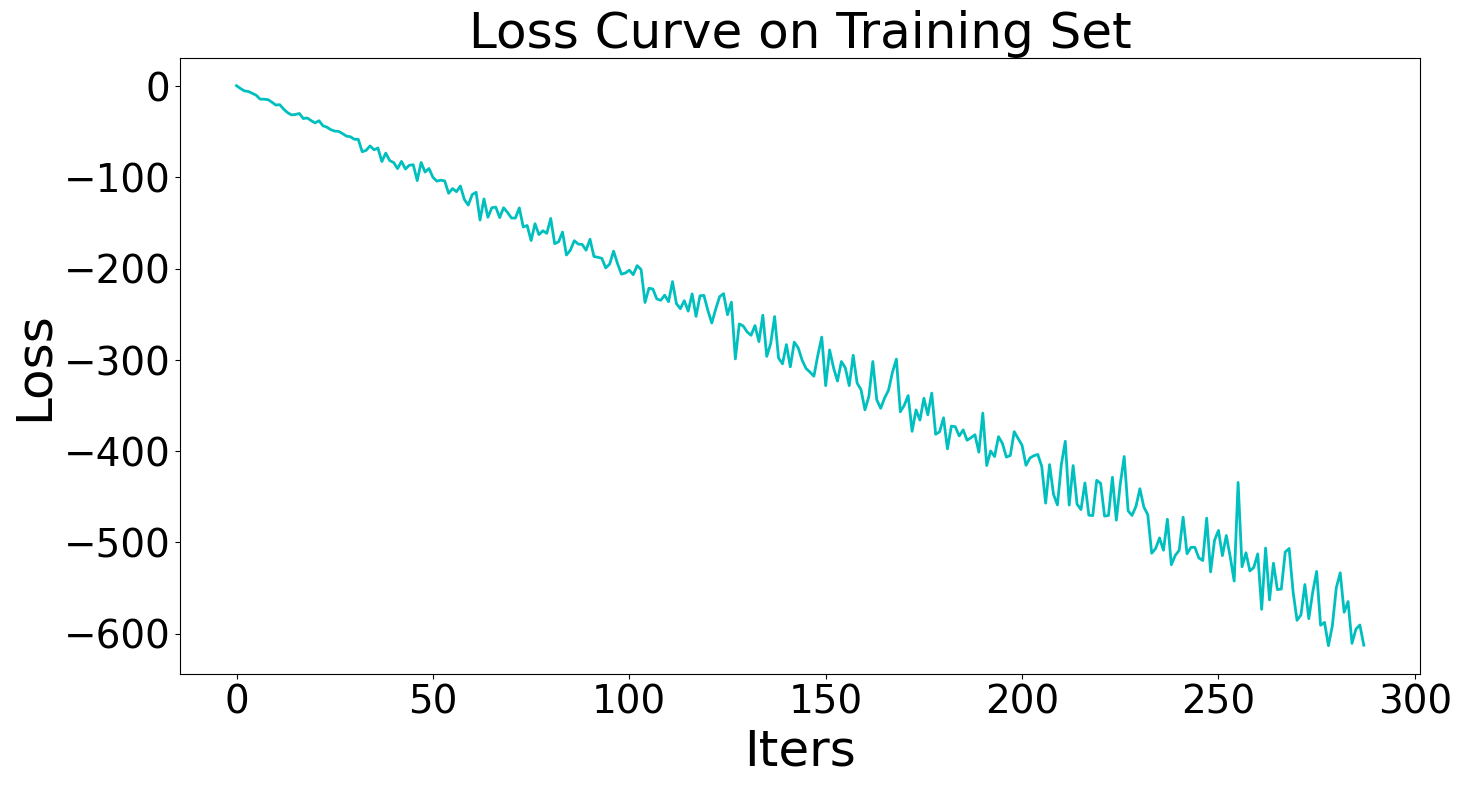

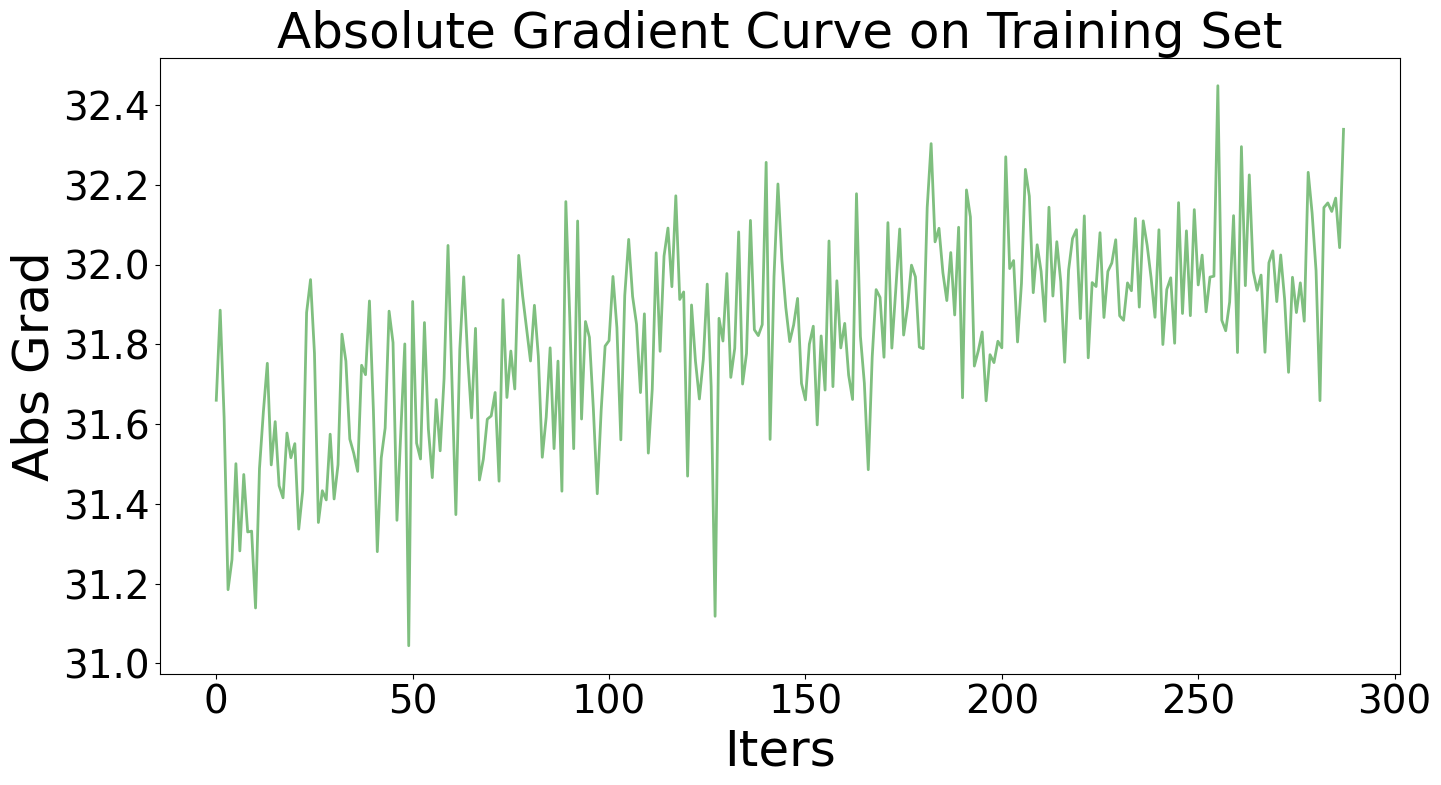

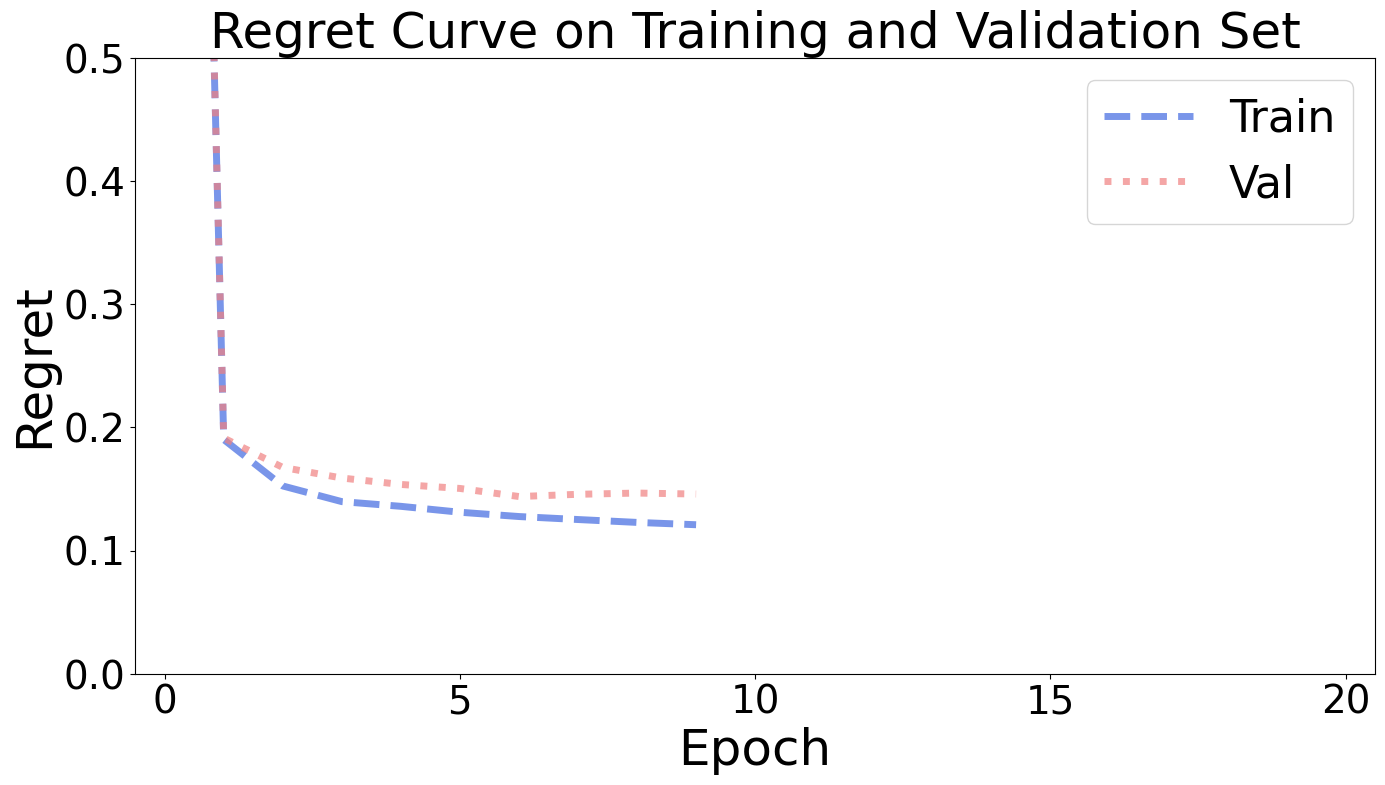

In [39]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)